## Import required packages

In [1]:
import os
import pathlib
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

## Load the dataset

In [2]:
DATASET_PATH = "data/mini_speech_commands"

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    tf.keras.utils.get_file(
        "mini_speech_commands.zip",
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir=".",
        cache_subdir="data",
    )

## Understanding the dataset

In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != "README.md") & (commands != ".DS_Store")]
print("Commands:", commands)

Commands: ['left' 'stop' 'no' 'down' 'up' 'yes' 'go' 'right']


In [4]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset="both",
)

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [5]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [6]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels


train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [7]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [8]:
for example_audio, example_labels in train_ds.take(1):
    print(example_audio.shape)
    print(example_labels.shape)

(64, 16000)
(64,)


In [9]:
label_names[[1, 1, 3, 0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

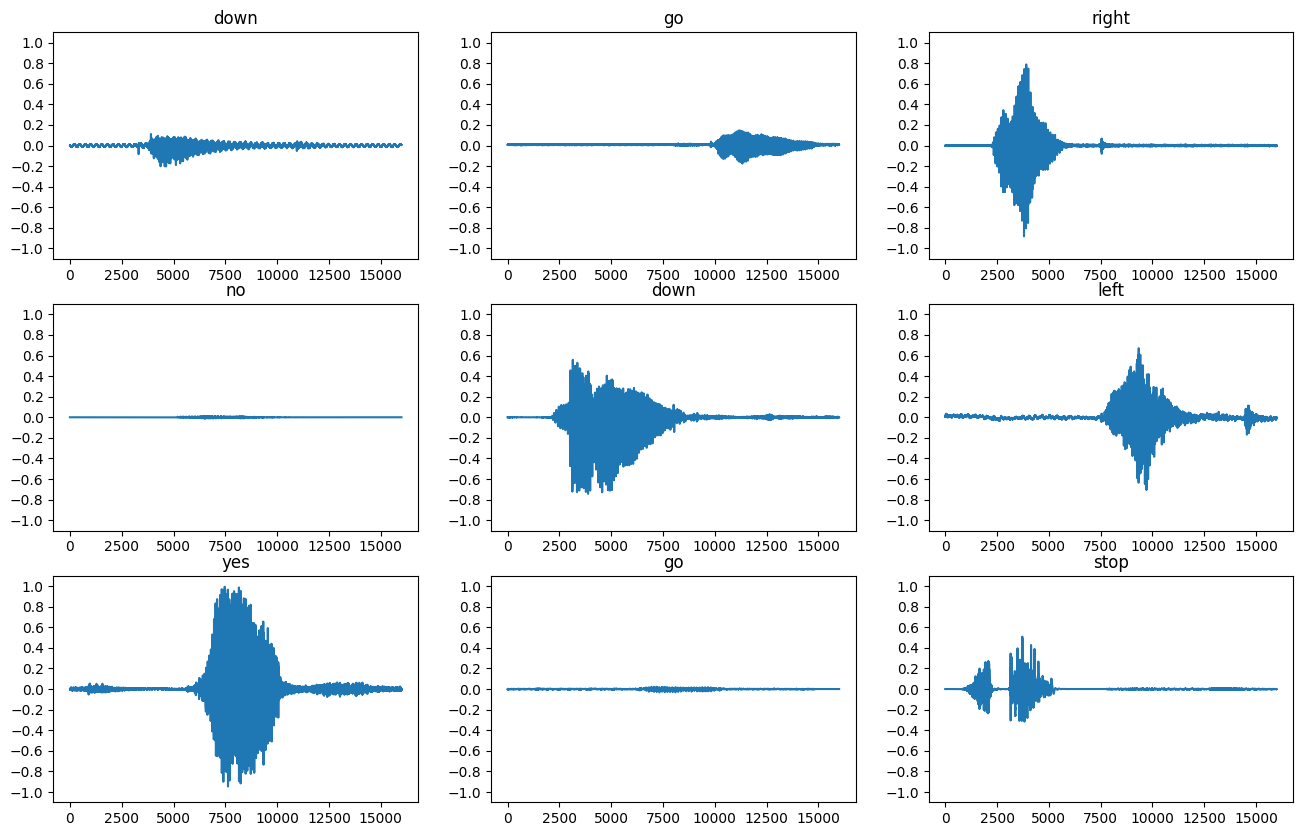

In [10]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i + 1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

In [11]:
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [12]:
from IPython import display

for i in range(5):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)

    print("Label:", label)
    print("Waveform shape:", waveform.shape)
    print("Spectrogram shape:", spectrogram.shape)
    print("Audio playback")
    display.display(display.Audio(waveform, rate=16000))

Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [13]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

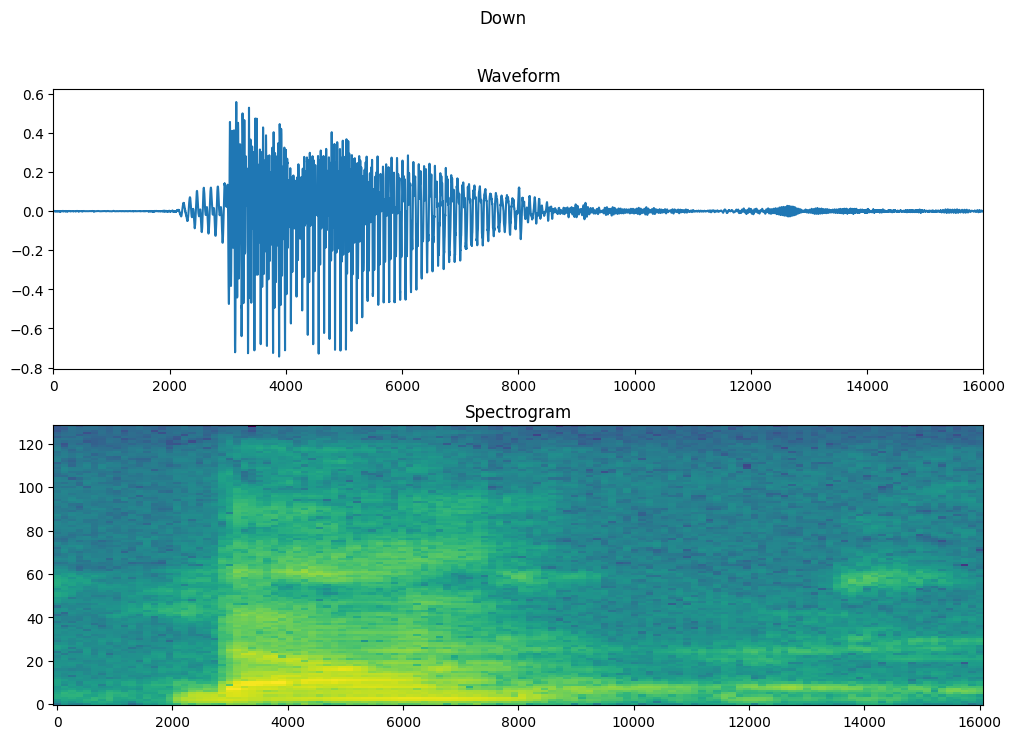

In [14]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title("Waveform")
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title("Spectrogram")
plt.suptitle(label.title())
plt.show()

In [15]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

In [16]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [17]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break

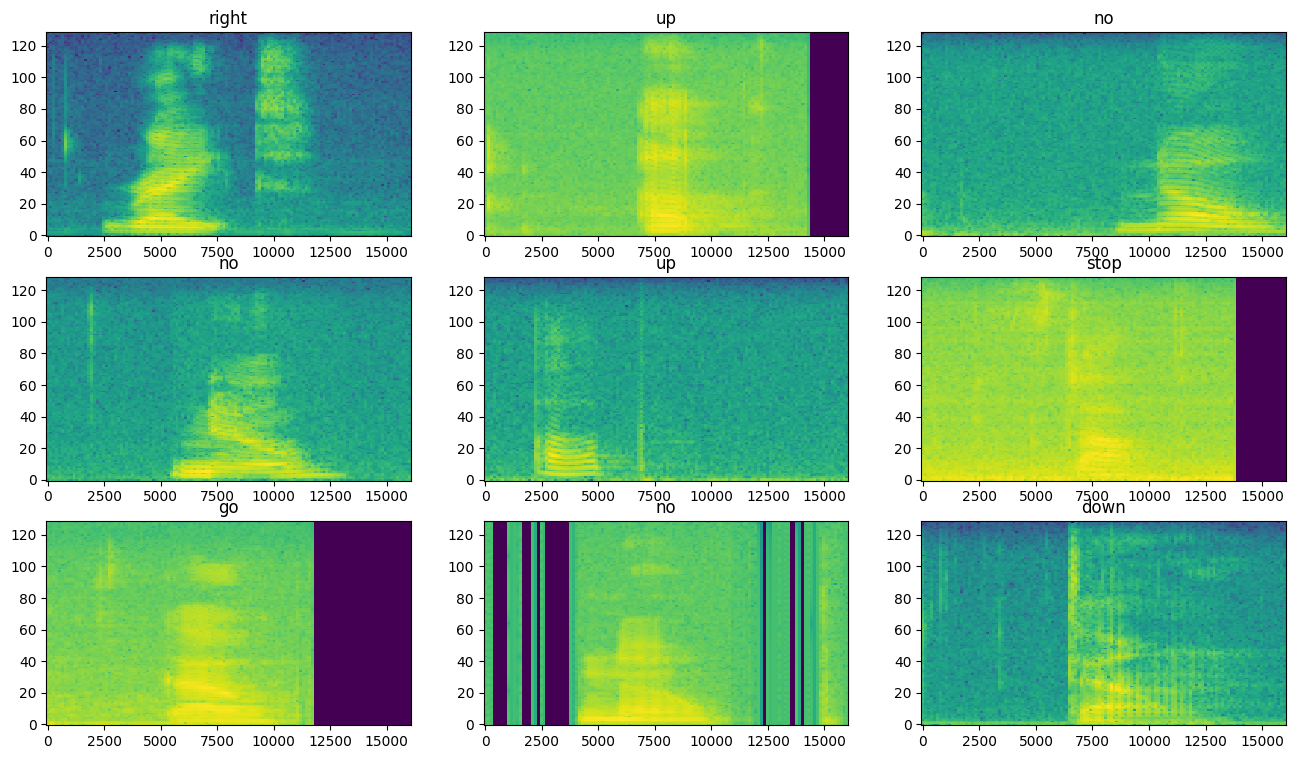

In [18]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Model Training

In [19]:
train_spectrogram_ds = (
    train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [20]:
input_shape = example_spectrograms.shape[1:]
print("Input shape:", input_shape)
num_labels = len(label_names)

norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Resizing(32, 32),
        norm_layer,
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.Conv2D(64, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_labels),
    ]
)

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [22]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 9s 19ms/step - loss: 1.7694 - accuracy: 0.3613 - val_loss: 1.3708 - val_accuracy: 0.5729
Epoch 2/10
100/100 [==============================] - 1s 9ms/step - loss: 1.2753 - accuracy: 0.5431 - val_loss: 0.9446 - val_accuracy: 0.7161
Epoch 3/10
100/100 [==============================] - 1s 9ms/step - loss: 0.9685 - accuracy: 0.6520 - val_loss: 0.8524 - val_accuracy: 0.7513
Epoch 4/10
100/100 [==============================] - 1s 9ms/step - loss: 0.7902 - accuracy: 0.7209 - val_loss: 0.7059 - val_accuracy: 0.7826
Epoch 5/10
100/100 [==============================] - 1s 9ms/step - loss: 0.6444 - accuracy: 0.7720 - val_loss: 0.6202 - val_accuracy: 0.8203
Epoch 6/10
100/100 [==============================] - 1s 9ms/step - loss: 0.5773 - accuracy: 0.7955 - val_loss: 0.5622 - val_accuracy: 0.8320
Epoch 7/10
100/100 [==============================] - 1s 9ms/step - loss: 0.5087 - accuracy: 0.8209 - val_loss: 0.5059 - val_accuracy: 0.8477
Epoch

## Model Evaluation

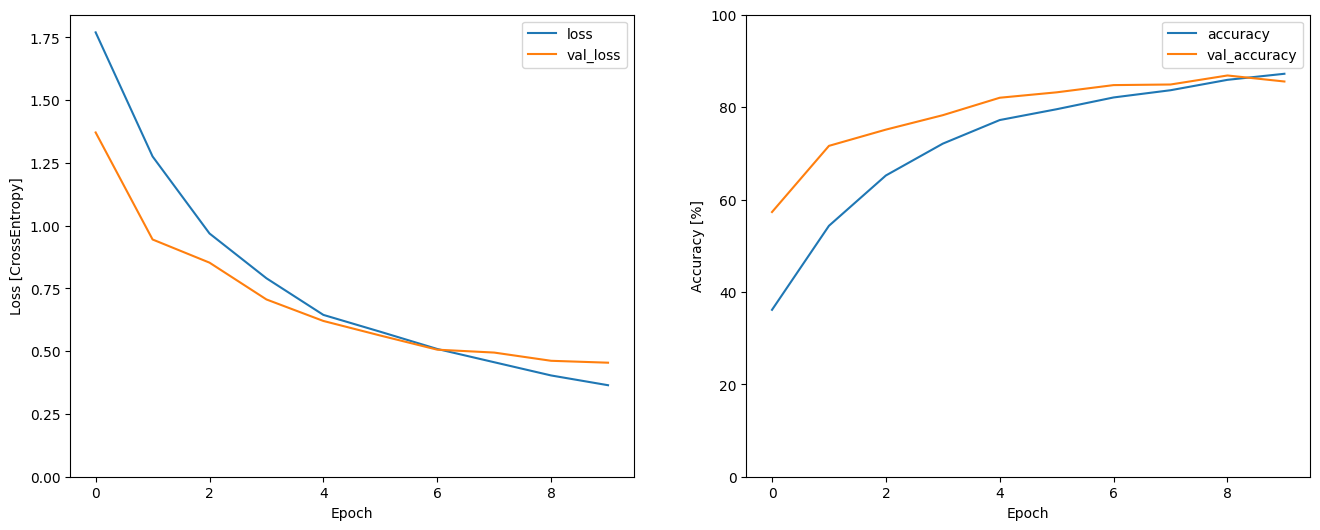

In [23]:
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics["loss"], metrics["val_loss"])
plt.legend(["loss", "val_loss"])
plt.ylim([0, max(plt.ylim())])
plt.xlabel("Epoch")
plt.ylabel("Loss [CrossEntropy]")

plt.subplot(1, 2, 2)
plt.plot(
    history.epoch,
    100 * np.array(metrics["accuracy"]),
    100 * np.array(metrics["val_accuracy"]),
)
plt.legend(["accuracy", "val_accuracy"])
plt.ylim([0, 100])
plt.xlabel("Epoch")
plt.ylabel("Accuracy [%]")
plt.show()

In [24]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 1s 66ms/step - loss: 0.4854 - accuracy: 0.8293


{'loss': 0.4854208827018738, 'accuracy': 0.8293269276618958}

In [25]:
y_pred = model.predict(test_spectrogram_ds)

13/13 [==============================] - 0s 4ms/step


In [26]:
y_pred = tf.argmax(y_pred, axis=1)

In [27]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s, lab: lab)), axis=0)

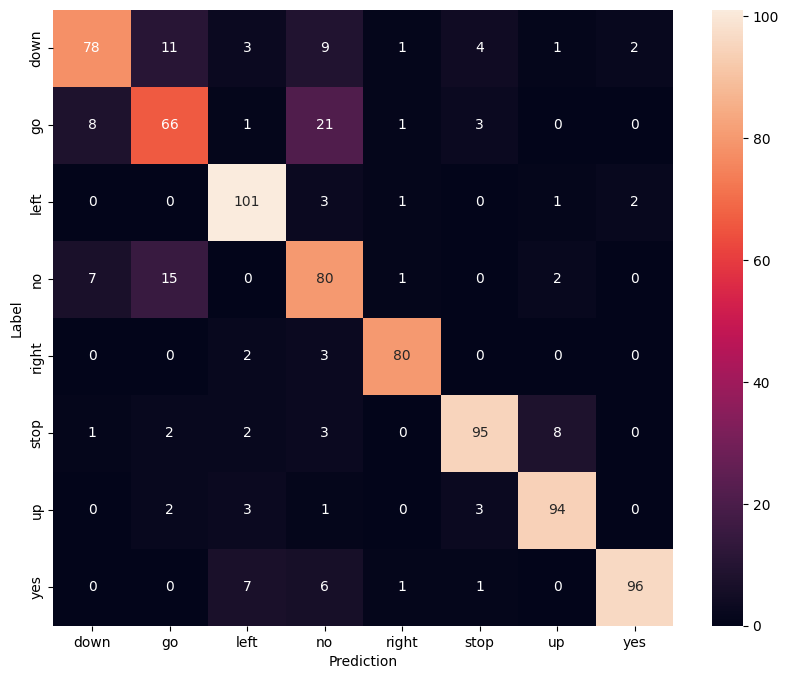

In [28]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_mtx, xticklabels=label_names, yticklabels=label_names, annot=True, fmt="g"
)
plt.xlabel("Prediction")
plt.ylabel("Label")
plt.show()

## Model Testing

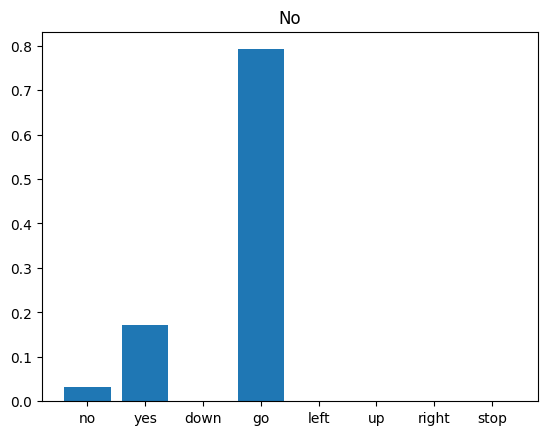

In [29]:
x = data_dir / "no/01bb6a2a_nohash_0.wav"
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(
    x,
    desired_channels=1,
    desired_samples=16000,
)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis, ...]

prediction = model(x)
x_labels = ["no", "yes", "down", "go", "left", "up", "right", "stop"]
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title("No")
plt.show()

display.display(display.Audio(waveform, rate=16000))